<a href="https://colab.research.google.com/github/comandi1969/AIFFEL_Online_Quest/blob/main/Exploration02/Exploration02_News_Summary_Abstractive_Extractive(final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 데이터 전처리를 위한 나머지 패키지 임포트
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# 데이터 준비
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(3)

,headlines,text
42548,"Fraud-hit PNB issued over 41,000 LoUs since 20...",The government has informed that fraud-hit PNB...
74313,I give Sunil Grover a call whenever I feel lik...,"Comedian-TV host Kapil Sharma, while respondin..."
22667,Try dumping garbage in front of L-G house: SC ...,Slamming civic authorities for poor waste mana...


In [ ]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [ ]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [ ]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [ ]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [ ]:
# 3개 데이터 확인
sampled_data = data.head(3)

for idx, row in sampled_data.iterrows():
    print(f"Article: {row['text']}")
    print(f"Headlines: {row['headlines']}")
    print("-" * 50)  # This will print a separator line

Article: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
Headlines: upGrad learner switches to career in ML & Al with 90% salary hike
--------------------------------------------------
Article: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
Headlines: Delhi techie wins free food from Swiggy for one year on CRED
--------------------------------------------------
Article

In [ ]:
# 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                          "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                          "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                          "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                          "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                          "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                          "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                          "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                          "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                          "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                          "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                          "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                          "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                          "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                          "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                          "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                          "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                          "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                          "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                          "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                          "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                          "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                          "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [ ]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
#    sentence = sentence.lower() # 텍스트 소문자화
   sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
   sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
   sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
   sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
   sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
   sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
   sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

   # 불용어 제거 (Text)
   if remove_stopwords:
       tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
   # 불용어 미제거 (Summary)
   else:
       tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
   return tokens

In [ ]:
temp_text = "Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."
temp_headline = "upGrad learner switches to career in ML & Al with 90% salary hike"

print("text: ", preprocess_sentence(temp_text, False)) # 기사가 짧아 불용어 처리는 제외
print("headline:", preprocess_sentence(temp_headline, False))

text:  Saurav Kant an alumnus of upGrad and IIIT PG Program in Machine learning and Artificial Intelligence was Sr Systems Engineer at Infosys with almost years of work experience The program and upGrad degree career support helped him transition to Data Scientist at Tech Mahindra with salary hike upGrad Online Power Learning has powered lakh careers
headline: upGrad learner switches to career in ML Al with salary hike


In [ ]:
# 전체 text 데이터에 대한 전처리
clean_text = []

for text in data['text']:
   clean_text.append(preprocess_sentence(text, False))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['Saurav Kant an alumnus of upGrad and IIIT PG Program in Machine learning and Artificial Intelligence was Sr Systems Engineer at Infosys with almost years of work experience The program and upGrad degree career support helped him transition to Data Scientist at Tech Mahindra with salary hike upGrad Online Power Learning has powered lakh careers', 'Kunal Shah credit card bill payment platform CRED gave users chance to win free food from Swiggy for one year Pranav Kaushik Delhi techie bagged this reward after spending CRED coins Users get one CRED coin per rupee of bill paid which can be used to avail rewards from brands like Ixigo BookMyShow UberEats Cult Fit and more', 'New Zealand defeated India by wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five match ODI series India lost an international match under Rohit Sharma captaincy after consecutive victories dating back to March The match witnessed India getting all out for their sevent

In [ ]:
# 전체 headlines 데이터에 대한 전처리
clean_headline = []

for headline in data['headlines']:
   clean_headline.append(preprocess_sentence(headline, False))

print("headlines 전처리 후 결과: ", clean_headline[:5])

headlines 전처리 후 결과:  ['upGrad learner switches to career in ML Al with salary hike', 'Delhi techie wins free food from Swiggy for one year on CRED', 'New Zealand end Rohit Sharma led India match winning streak', 'Aegon life iTerm insurance plan helps customers save tax', 'Have known Hirani for yrs what if MeToo claims are not true Sonam']


In [ ]:
data['text'] = clean_text
data['headlines'] = clean_headline

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 69
텍스트의 평균 길이 : 56.1561813745425
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.289406262708418


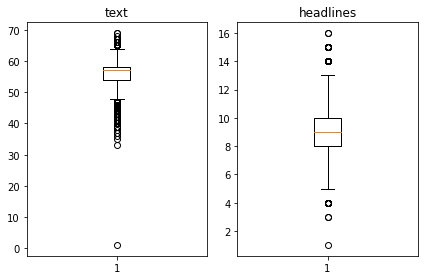

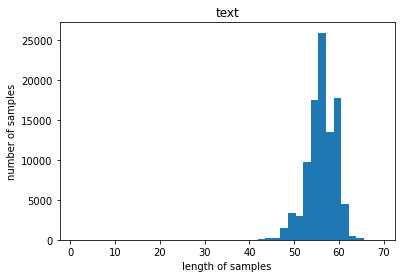

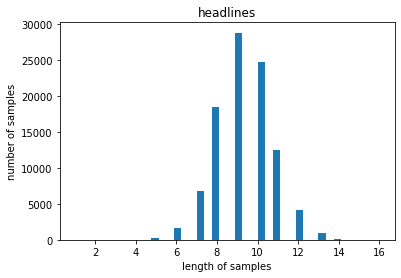

In [ ]:
# 길이 분포 시각화
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']] # len(s.split())은 단어 수를 계산
headline_len = [len(s.split()) for s in data['headlines']] # len(s.split())은 단어 수를 계산

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headline_len)))
print('요약의 최대 길이 : {}'.format(np.max(headline_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headline_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
text_max_len = 60 # Text의 최대 길이
headline_max_len = 12 # Headline의 최대 길이

In [ ]:
def below_threshold_len(max_len, nested_list):
 cnt = 0
 for s in nested_list:
   if(len(s.split()) <= max_len):
       cnt = cnt + 1
 print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [ ]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.9470414802765352
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9889589263928427


In [ ]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len) & data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 92225


In [ ]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upGrad learner switches to career in ML Al wit...,Saurav Kant an alumnus of upGrad and IIIT PG P...,sostoken upGrad learner switches to career in ...,upGrad learner switches to career in ML Al wit...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah credit card bill payment platform C...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma led India match w...,New Zealand defeated India by wickets in the f...,sostoken New Zealand end Rohit Sharma led Indi...,New Zealand end Rohit Sharma led India match w...
3,Aegon life iTerm insurance plan helps customer...,With Aegon Life iTerm Insurance plan customers...,sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,sostoken Rahat Fateh Ali Khan denies getting n...,Rahat Fateh Ali Khan denies getting notice for...


In [ ]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[84311 28003 24653 ... 65768 32575 33046]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)
print('훈련 데이터의 수 :', int(len(encoder_input) - n_of_val))

테스트 데이터의 수 : 18445
훈련 데이터의 수 : 73780


In [ ]:
encoder_input_train = encoder_input[:-n_of_val] # 훈련 데이터
decoder_input_train = decoder_input[:-n_of_val] # 훈련 데이터 sostoken
decoder_target_train = decoder_target[:-n_of_val] # 훈련 데이터 eostoken

encoder_input_test = encoder_input[-n_of_val:] # 테스트 데이터
decoder_input_test = decoder_input[-n_of_val:] # 테스트 데이터 sostoken​
decoder_target_test = decoder_target[-n_of_val:] # 테스트 데이터 eostoken​

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

print(encoder_input_train[:1])
print(decoder_input_train[:1])
print(decoder_target_train[:1])

print(encoder_input_test[:1])
print(decoder_input_test[:1])
print(decoder_target_test[:1])

훈련 데이터의 개수 : 73780
훈련 레이블의 개수 : 73780
테스트 데이터의 개수 : 18445
테스트 레이블의 개수 : 18445
['brewery in Denmark has made beer using litres of recycled urine collected from music festival in Europe The beer named Pisner does not contain human waste but is produced from fields of malting barley fertilised with urine The Danish Agriculture and Food Council has named the concept beercycling']
['sostoken Danish brewery creates beer using recycled urine']
['Danish brewery creates beer using recycled urine eostoken']
['Russia is allowing thousands of North Korean workers to enter the country and giving them new work permits in potential violation of UN sanctions according to reports Over new North Korean workers have registered in Russia and new work permits have been issued since the UN imposed the ban last year reports quoting Russian government records showed']
['sostoken Russia gives work permit to Koreans despite UN ban Report']
['Russia gives work permit to Koreans despite UN ban Report eostoken']


In [ ]:
# 단어 집합(vocabulary) 만들기
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [ ]:
threshold = 5
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
   total_freq = total_freq + value

   # 단어의 등장 빈도수가 threshold보다 작으면
   if(value < threshold):
       rare_cnt = rare_cnt + 1
       rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68022
등장 빈도가 4번 이하인 희귀 단어의 수: 42210
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 25812
단어 집합에서 희귀 단어의 비율: 62.05345329452236
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.7335693113373092


In [ ]:
src_vocab = 25000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 25000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[13456, 3, 4549, 7, 118, 2881, 238, 4582, 4, 8889, 5963, 2106, 19, 940, 972, 3, 1670, 1, 2881, 305, 312, 26, 4133, 394, 2083, 83, 12, 1356, 19, 3868, 4, 15, 5963, 1, 6096, 3630, 5, 416, 838, 7, 305, 1, 2979], [466, 1, 734, 45, 1, 8736, 3, 4, 3747, 3838, 20, 102, 55, 4, 352, 90, 586, 7068, 2270, 399, 9, 71, 1288, 41, 1421, 4004, 1596, 107, 13, 12, 3, 1, 21653, 4, 194, 105, 1, 493, 126, 18, 241, 90, 5, 1731, 544, 100, 1, 94, 4, 5212, 5842, 1993, 2, 1132, 1, 122, 2, 418, 3, 352], [1, 40, 12, 1893, 2594, 1121, 6, 5964, 286, 3, 1719, 2, 13036, 96, 15, 43, 1192, 1, 1121, 35, 76, 2020, 2, 12637, 13036, 1, 1192, 20, 286, 157, 24, 13930, 85, 8890, 14, 387, 485, 2, 24, 688, 153, 9, 40, 62, 7, 324, 1, 48, 2, 13036, 71, 1, 1192, 14, 546]]


In [ ]:
tar_tokenizer = Tokenizer() # src_tokenizer 참고
tar_tokenizer.fit_on_texts(decoder_input_train) # decoder_input_train 디코더의 입력 시퀀스

In [ ]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
   total_freq = total_freq + value

   # 단어의 등장 빈도수가 threshold보다 작으면
   if(value < threshold):
       rare_cnt = rare_cnt + 1
       rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29375
등장 빈도가 4번 이하인 희귀 단어의 수: 18170
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11205
단어 집합에서 희귀 단어의 비율: 61.855319148936175
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.136846390602851


In [ ]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)  # 단어 집합 재생성
tar_tokenizer.fit_on_texts(decoder_target_train)  # 단어 집합 재생성

# 토큰화기에 여러 번 fit_on_texts를 호출하면 단어 인덱스가 재설정되지 않습니다. 대신 업데이트됩니다.
# 따라서 이 문맥에서 토큰화기의 어휘는 decoder_input_train 및 decoder_target_train 모두를 기반으로 합니다.

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 5206, 7888, 1563, 1454, 231, 7889, 3610], [1, 315, 282, 20, 4, 18, 6, 21, 40, 90, 108, 103], [1, 14, 693, 1786, 551, 3, 5436, 3514, 572, 9, 1869], [1, 44, 216, 7389, 3515, 262, 16], [1, 146, 1091, 3, 141, 110, 8464, 10059, 2318]]
target
decoder  [[5206, 7888, 1563, 1454, 231, 7889, 3610, 2], [315, 282, 20, 4, 18, 6, 21, 40, 90, 108, 103, 2], [14, 693, 1786, 551, 3, 5436, 3514, 572, 9, 1869, 2], [44, 216, 7389, 3515, 262, 16, 2], [146, 1091, 3, 141, 110, 8464, 10059, 2318, 2]]


In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train)) # 0
print('삭제할 테스트 데이터의 개수 :', len(drop_test)) # 0

# 삭제할 훈련 데이터, 테스트 데이터 없음
# encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
# decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
# decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

# encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
# decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
# decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 73780
훈련 레이블의 개수 : 73780
테스트 데이터의 개수 : 18445
테스트 레이블의 개수 : 18445


In [ ]:
# 패딩 추가하기,  최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춤
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')

In [ ]:
# 모델 설계하기
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

# 최종 출력 값인 encoder_output3, state_h3, state_c3는 디코더 단계에서 중요할 것이며,
# state_h3와 state_c3는 디코더의 LSTM 레이어의 초기 상태가 됩니다.

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      3200000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
# 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3]) # 마지막 인코더 LSTM 레이어의 출력을 참조

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      3200000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [ ]:
# 모델 훈련하기
from tensorflow.keras.optimizers import Adam
# RMSprop은 주로 잡음이 많은 데이터셋에 특히 유용
# model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999), loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
         validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
         batch_size=128, callbacks=[es], epochs=200)

Epoch 1/200
577/577 [==============================] - 45s 67ms/step - loss: 6.2348 - val_loss: 5.6763
Epoch 2/200
577/577 [==============================] - 39s 67ms/step - loss: 5.6728 - val_loss: 5.5523
Epoch 3/200
577/577 [==============================] - 39s 67ms/step - loss: 5.5754 - val_loss: 5.4793
Epoch 4/200
577/577 [==============================] - 39s 67ms/step - loss: 5.5033 - val_loss: 5.4277
Epoch 5/200
577/577 [==============================] - 38s 67ms/step - loss: 5.4276 - val_loss: 5.3239
Epoch 6/200
577/577 [==============================] - 39s 67ms/step - loss: 5.3078 - val_loss: 5.2136
Epoch 7/200
577/577 [==============================] - 39s 67ms/step - loss: 5.2052 - val_loss: 5.1334
Epoch 8/200
577/577 [==============================] - 39s 67ms/step - loss: 5.1171 - val_loss: 5.0549
Epoch 9/200
577/577 [==============================] - 39s 67ms/step - loss: 5.0333 - val_loss: 4.9862
Epoch 10/200
577/577 [==============================] - 39s 67ms/step - l

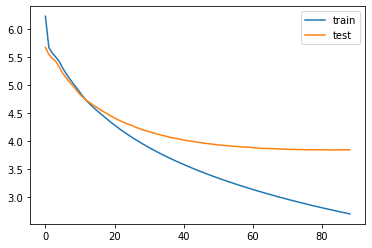

In [ ]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# 인퍼런스(추론) 모델 구현
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
   [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
   [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
   # 입력으로부터 인코더의 상태를 얻음
   e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
    # 디코딩을 시작하기 위해 디코더에 입력될 첫 번째 토큰, 즉 "시작 토큰"을 설정하는 역할​
   target_seq = np.zeros((1,1)) # target_seq는 2차원 배열로, 행이 1개이고 열이 1개, [[0]]
   target_seq[0, 0] = tar_word_to_index['sostoken']

   stop_condition = False
   decoded_sentence = ''
   while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

       output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) # 이 코드는 현재의 입력 토큰 및 인코더의 출력 및 상태값을 사용하여 디코더로 다음 토큰을 예측
       sampled_token_index = np.argmax(output_tokens[0, -1, :]) # 배치의 첫 번째 시퀀스(0), 시퀀스의 마지막 토큰(-1) 및 모든 어휘 확률 중 가장 가능성이 높은 다음 단어의 인덱스 선택
       sampled_token = tar_index_to_word[sampled_token_index]

       if (sampled_token!='eostoken'):
           decoded_sentence += ' '+sampled_token

       #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
       if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
           stop_condition = True

       # 길이가 1인 타겟 시퀀스를 업데이트
       target_seq = np.zeros((1,1))
       target_seq[0, 0] = sampled_token_index

       # 상태를 업데이트 합니다.
       e_h, e_c = h, c

   return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
   temp=''
   for i in input_seq:
       if (i!=0):
           temp = temp + src_index_to_word[i]+' '
   return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
   # [[YOUR CODE]]
   temp=''
   start_tok = tar_word_to_index['sostoken']
   end_tok = tar_word_to_index['eostoken']

   for i in input_seq:
       if (i!=0 and i!=start_tok and i!=end_tok):
           temp = temp + tar_index_to_word[i]+' '
   return temp

In [ ]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

for i in range(0, 5):
   print("원문 :", seq2text(encoder_input_test[i]))
   print("실제 요약 :", seq2summary(decoder_input_test[i]))
   print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
   print("\n")

원문 : russia is allowing thousands of north korean workers to enter the country and giving them new work permits in potential violation of un sanctions according to reports over new north korean workers have registered in russia and new work permits have been issued since the un imposed the ban last year reports quoting russian government records showed 
실제 요약 : russia gives work permit to despite un ban report 
예측 요약 :  korea to buy us military embargo for korea


원문 : author chetan bhagat has said that the hindi film adaptation of his novel half girlfriend was too in parts and could have certainly turned out better chetan added that with arjun kapoor as the leading man the expectations were high the film which released on may was rated by hindustan times and by india today 
실제 요약 : film version of my novel half girlfriend too chetan 
예측 요약 :  my actors have been made in my film irrfan


원문 : opener mayank agarwal scored runs off balls in his first ever test innings as india ended the 

In [ ]:
# SMMMA 추출적 요약 구현
# 라이브러리 임포트
from importlib.metadata import version
import nltk
import tensorflow
from summa.summarizer import summarize
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [ ]:
# 데이터 로드
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
90853,Fyre Festival organisers face $100 mn suit for...,Celebrity lawyer Mark Geragos has filed a $100...
87036,Anand Mahindra wants to buy car in Rajinikanth...,Mahindra Group's Anand Mahindra on Monday twee...
27881,We are feeling great pain due to sanctions: Ki...,Following his summit with US President Donald ...
86619,"Pak man tweets to Swaraj about ailing child, g...",India has issued a medical visa to a two-and-a...
70979,"How do hurricanes, the most violent storms on ...",Storms that form over the Atlantic and eastern...
4284,Cook first England cricketer to be knighted si...,"Former England captain Alastair Cook, who reti..."
8914,UK MP 'mocks suicide' during Parliament debate,"Clive Lewis, Member of the Parliament from the..."
32170,5 SC judges to hear plea on rejection of motio...,A five-judge Supreme Court bench will hear the...
41401,Man accused of raping minor lynched in Ghaziabad,A 24-year-old man accused of raping an eight-y...
41421,"16 dead, 1400 injured in Gaza-Israel border pr...",Israel's military has killed at least 16 Pales...


In [ ]:
# 데이터 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [ ]:
# ratio를 정하기 위해 다양한 값으로 테스트 => 0.6으로 결정
for i in range(0, 5):
    text = data.iloc[i]['text']
    print(f'[원문]\n{text}')
    headline = data.iloc[i]['headlines']
    print(f'[실제 요약]\n{headline}')
    summary = summarize(text, ratio=0.6)
    print(f'[예측 요약]\n{summary}')
    print('='*80)

[원문]
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
[실제 요약]
upGrad learner switches to career in ML & Al with 90% salary hike
[예측 요약]
upGrad's Online Power Learning has powered 3 lakh+ careers.
[원문]
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
[실제 요약]
Delhi techie wins free food from Swiggy for one year on CRED
[예측 요약]
Users get one CRED coin per rupee of bill paid,

In [ ]:
# Summa summarize()로 요약 추출
def custom_summary(text):
    summarized = summarize(text, ratio=0.6) # ratio =0.6
    words = summarized.split()
    if len(words) > 12: # 기사 타이틀이 15 단어가 넘으면 절삭
        return ' '.join(words[:12])
    return summarized

data['summary'] = data['text'].apply(custom_summary)

In [ ]:
# sampled_data = data.sample(3)
sampled_data = data.head(5)

for idx, row in sampled_data.iterrows():
    print(f"[Article]: {row['text']}")
    print(f"[Headlines]: {row['headlines']}")
    print(f"[Summary]: {row['summary']}")
    print("-" * 80)

[Article]: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
[Headlines]: upGrad learner switches to career in ML & Al with 90% salary hike
[Summary]: upGrad's Online Power Learning has powered 3 lakh+ careers.
--------------------------------------------------------------------------------
[Article]: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
[Headlines]: Delhi tech

In [ ]:
# 회고
# 처음해보는 NLP라 낯설고 전에 배운 판다스 명령어도 생각이 안 나고 많이 힘들고 여러운 노드였습니다.
# LSM 코드랑 챗GPT를 활용해 어찌어찌 프로젝트는 완성했지만 많이 어설프고 부족하는 생각이 듭니다
# 이미지 같은 경우 리사이징이나 증강을 할 수 있는데 텍스트는 유사한 접근 방식이 있는 것인지?
# 텍스트 예측과에 대한 출력 외 다른 평가 및 시각화 방법은 어떤 것이 인는지 궁금합니다.
#